In [1]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=3a93e79c5cbc06f824759364288f5692906f6055dd6dbe7da82b69375f8b2d7c
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [2]:
# import the necessary packages
from imutils import paths
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt

In [3]:
def find_stickynote(image):
    # convert the image to grayscale, blur it, and detect edges
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(gray, 35, 125)
    # find the contours in the edged image and keep the largest one;
    # we'll assume that this is our piece of paper in the image
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)
    M = cv2.moments(c)
    # compute the bounding box of the of the note region and return it
    return cv2.minAreaRect(c), [int(M["m10"] / M["m00"]),int(M["m01"] / M["m00"])]

Let's try to apply the Triangle Similiarity principle in our problem to calculate the distance of the stickynote from camera. The triangle similarity goes something like this: Let’s say we have a marker or object with a known width W. We then place this marker some distance D from our camera. We take a picture of our object using our camera and then measure the apparent width in pixels P. This allows us to derive the perceived focal length F of our camera:

F = (P x D) / W

For example, let’s say I place a standard piece of 8.5 x 11in piece of paper (horizontally; W = 11) D = 24 inches in front of my camera and take a photo. When I measure the width of the piece of paper in the image, I notice that the perceived width of the paper is P = 248 pixels.

My focal length F is then:

F = (248px x 24in) / 11in = 543.45

In the sample Image given in the question, It's shown that D=30cm. By calculating the pixel size of the sticky note in the image, we can calculate W.

In [4]:
def distance_to_camera(knownWidth, focalLength, perWidth):
    # compute and return the distance from the maker to the camera
    return (knownWidth * focalLength) / perWidth

In [5]:
# initialize the known distance from the camera to the object, which
# in this case is 30cm
KNOWN_DISTANCE = 30
# initialize the known object width, which in this case, we assume the sticky note of
# size is 5cm wide
KNOWN_WIDTH = 5

**I am making the assumption that the contour with the largest area is our sticky note. This assumption works for this particular case when our webcam is not moving and no new object is introduced, but in reality finding the sticky note in an image is highly application specific and we can use either cascadeclassifier, YOLO algorithm or  other deep learning models which need training and test data. SO for the sake of simplicity, I have decided to move on with this model as the objective is to build a simple model**

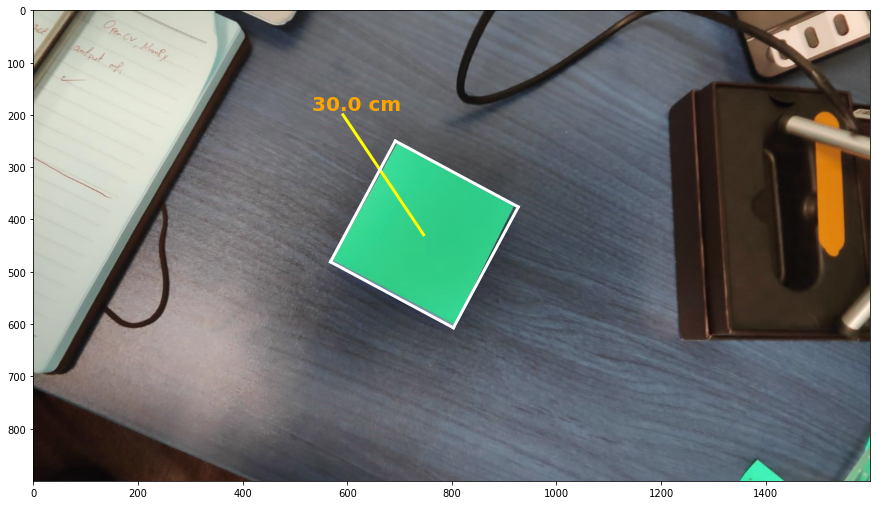

In [6]:
# load the  image that contains an object that is KNOWN TO BE 5cm
# from our camera, then find the sticky note in the image, and initialize
# the focal length
image = cv2.imread("../input/q-webcam-feed/webcam_feed.jpg")
sticky_note, centre = find_stickynote(image)
focalLength = (sticky_note[1][0] * KNOWN_DISTANCE) / KNOWN_WIDTH
dist = distance_to_camera(KNOWN_WIDTH, focalLength, sticky_note[1][0])
# draw a bounding box around the image and display it
box = cv2.cv.BoxPoints(sticky_note) if imutils.is_cv2() else cv2.boxPoints(sticky_note)
box = np.int0(box)
plt.figure(figsize=(15,15))
plt.plot([centre[0],box[1][0]-100],[centre[1],box[1][1]-50],color="yellow", linewidth=3)
plt.plot([box[1][0],box[2][0]],[box[1][1],box[2][1]],color="white", linewidth=3)
plt.plot([box[2][0],box[3][0]],[box[2][1],box[3][1]],color="white", linewidth=3)
plt.plot([box[3][0],box[0][0]],[box[3][1],box[0][1]],color="white", linewidth=3)
plt.plot([box[0][0],box[1][0]],[box[0][1],box[1][1]],color="white", linewidth=3)
plt.text(box[1][0]-160, box[1][1]-60, "{} cm".format(str(dist)), color="orange", fontdict={"fontsize":20,"fontweight":'bold'})
plt.imshow(image)
plt.show()

Now for live footage, we can use a forloop that perform the same task for continuos frames at a fixed interval.